# Using Julia via pyjulia

This notebook demonstrates the application of pyABC to models defined in [Julia](https://julialang.org/).

In [1]:
import tempfile

import matplotlib.pyplot as plt

import pyabc
from pyabc import ABCSMC, RV, Distribution, MulticoreEvalParallelSampler
from pyabc.external.julia import Julia

pyabc.settings.set_figure_params('pyabc')  # for beautified plots

As demonstration example, we use an [SIR disease dynamics model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). For simulation, we use an implementation of [Gillespie's direct algorithm](https://www.sciencedirect.com/science/article/pii/0021999176900413) in the [DifferentialEquations.jl](https://diffeq.sciml.ai/stable/) package.

The code consists of multiple functions in the file `model_julia/SIR.jl`, wrapped in the namespace of a module `SIR`. Importing the module and dependencies can take some time due to pre-processing.

In [2]:
%%time
jl = Julia(module_name='SIR', source_file='model_julia/SIR.jl')

CPU times: user 33.7 s, sys: 1.46 s, total: 35.1 s
Wall time: 34.9 s


In [3]:
jl.display_source_ipython()

The Julia code defines functions for model and distance. The model returns a dictionary, whose entries are internally converted to numpy arrays, while the distance returns a single floating value. Further, also the observed data can be defined in and imported from Julia. Note that also only a subset of model, distance and observation can be defined in Julia, and combined with Python objects.

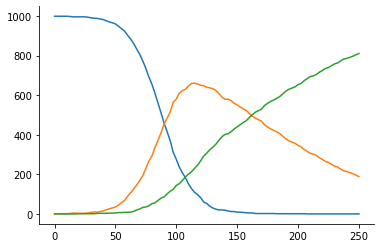

In [4]:
model = jl.model()
distance = jl.distance()
obs = jl.observation()

_ = plt.plot(obs['t'], obs['u'])

We use a prior on log-scale, the Julia model applies the corresponding transformation internally.

In [5]:
gt_par = {'p1': -4.0, 'p2': -2.0}

# parameter limits and prior
par_limits = {
    'p1': (-5, -3),
    'p2': (-3, -1),
}
prior = Distribution(
    **{key: RV('uniform', lb, ub - lb) for key, (lb, ub) in par_limits.items()}
)

If we use parallelization, we need to call all julia functions once before, to perform necessary pre-compiling:

In [6]:
distance(model(gt_par), model(gt_par))

297286.7590759076

We are all set to run an analysis, even with parallelization via multi-processing:

In [7]:
abc = ABCSMC(
    model,
    prior,
    distance,
    sampler=MulticoreEvalParallelSampler(),
)
db = tempfile.mkstemp(suffix='.db')[1]
abc.new('sqlite:///' + db, obs)
h = abc.run(max_nr_populations=10)

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2021-11-18 17:21:06>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 2.18842571e+05.
ABC INFO: Accepted: 100 / 212 = 4.7170e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 1.45222795e+05.
ABC INFO: Accepted: 100 / 203 = 4.9261e-01, ESS: 7.8092e+01.
ABC INFO: t: 2, eps: 8.71552898e+04.
ABC INFO: Accepted: 100 / 268 = 3.7313e-01, ESS: 8.9681e+01.
ABC INFO: t: 3, eps: 5.17737477e+04.
ABC INFO: Accepted: 100 / 211 = 4.7393e-01, ESS: 9.0513e+01.
ABC INFO: t: 4, eps: 2.39628036e+04.
ABC INFO: Accepted: 100 / 346 = 2.8902e-01, ESS: 9.3795e+01.
ABC INFO: t: 5, eps: 1.14595719e+04.
ABC INFO: Accepted: 100 / 317 = 3.1546e-01, ESS: 8.1326e+01.
ABC INFO: t: 6, eps: 6.61310965e+03.
ABC INFO: Accepted: 100 / 403 = 2.4814e-01, ESS: 8.4728e+01.
ABC INFO: t: 7, eps: 3.66662784e+03.
ABC INFO: Accepted: 100 / 556 = 1.7986e-01, ESS: 6.2655e+01.
ABC INFO: t: 8, eps: 1.90359721e+03.
ABC INFO: Accepte

The posterior marginals show that the data constrain the parameters well:

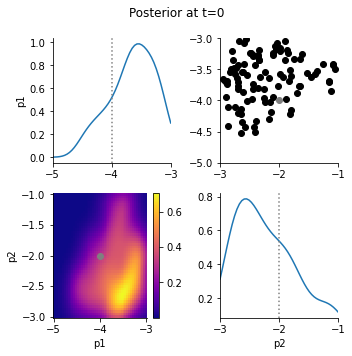

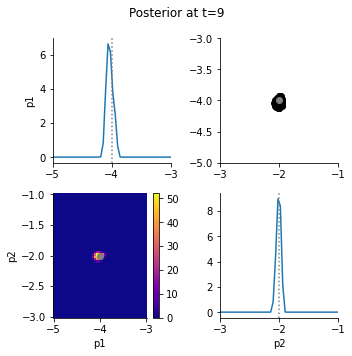

In [8]:
for t in [0, h.max_t]:
    pyabc.visualization.plot_kde_matrix_highlevel(
        h,
        t=t,
        limits=par_limits,
        refval=gt_par,
        refval_color='grey',
    )
    plt.gcf().suptitle(f'Posterior at t={t}')
    plt.gcf().tight_layout()

The accepted simulations closely match the observed data well, as we can see from data plots:

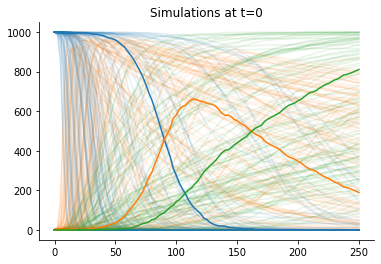

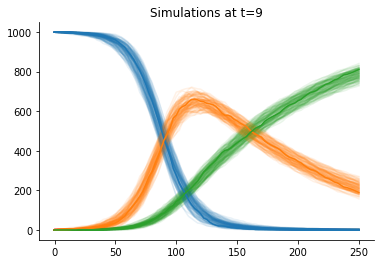

In [9]:
def plot_data(sumstat, weight, ax, **kwargs):  # noqa: ARG001
    """Plot a single trajectory"""
    for i in range(3):
        ax.plot(sumstat['t'], sumstat['u'][:, i], color=f'C{i}', alpha=0.1)


for t in [0, h.max_t]:
    _, ax = plt.subplots()
    pyabc.visualization.plot_data_callback(
        h,
        plot_data,
        t=t,
        ax=ax,
    )
    ax.plot(obs['t'], obs['u'])
    ax.set_title(f'Simulations at t={t}')